# This version of the notebook contains printouts from various things I've tried and helper functions that I've since depreciated (likely due to writing better versions).
--------
## Run the regular notebook `Quadcopter_Project.ipynb` for a cleaner presentation

# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
        
        ## Added the following function to be compatible with my file_write function
        self.params = None
        self.score = 0
    
    def reset_episode(self):
        state = self.task.reset()
        return state
    
    def act(self, state):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [2]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 3.                                     # time limit of the episode
init_pose = np.array([0., 0., 0.1, 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0., 0., 10.])            # target pose

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)

In [3]:
def file_write(agent, train_log=False):
    """
    Modified and turned existing file writting code into a function
    """
    ## Setup
    done = False
    labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
              'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
              'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
    results = {x : [] for x in labels}
    
    ## Changes the file desitnation if logging training (train_log=True)
    file_output = 'train_data.txt' if train_log else 'data.txt'

    # Run the simulation, and save the results.
    with open(file_output, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(labels)
        state = agent.reset_episode() # start a new episode
        while True:
            rotor_speeds = agent.act(state)
            _, _, done = agent.task.step(rotor_speeds)
            to_write = [agent.task.sim.time] + list(agent.task.sim.pose) + list(agent.task.sim.v) + list(agent.task.sim.angular_v) + list(rotor_speeds)
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
            writer.writerow(to_write)
            
            ## Writes the params of this run to a new line in the file if True
            if train_log:
                to_write = [agent.params] + [agent.task.params]
                writer.writerow(to_write)
                
            if done:
                print("Proximity = {:7.3f}, Agent Parameters = {}, Task Parameters = {}".format(agent.task.target_proximity, agent.params, agent.task.params), end="")  # [debug]
                break

    return results

results = file_write(agent)

Proximity =   4.381, Agent Parameters = None, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

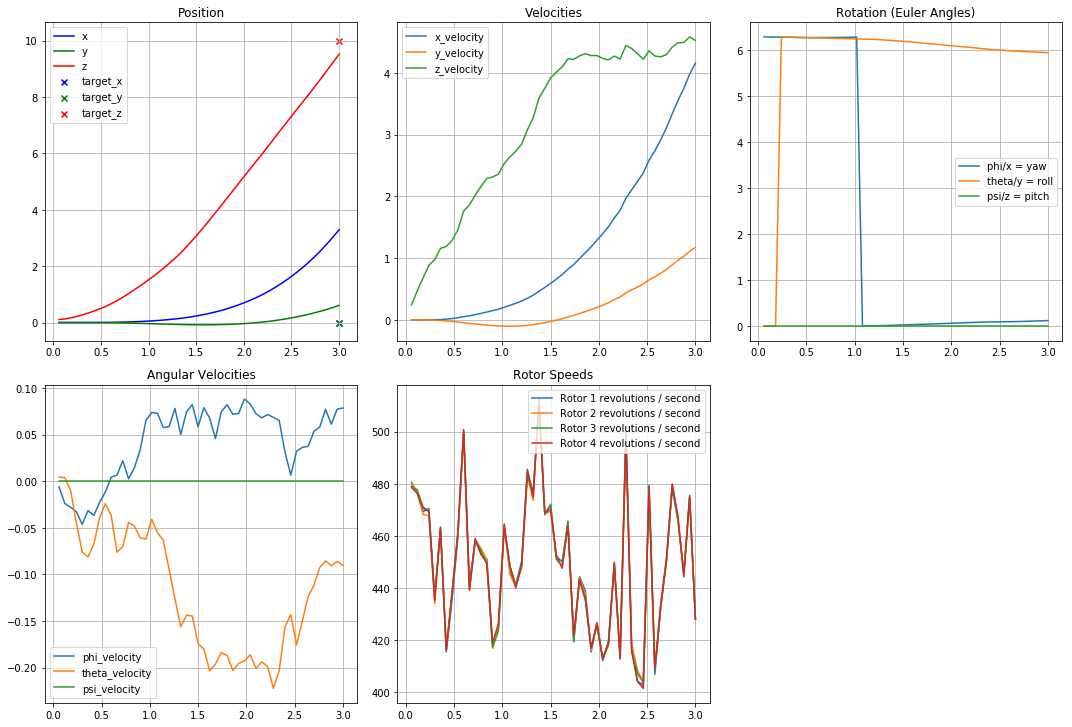

Final Position: [ 3.29404031  0.60804127  9.52119816  0.12367366  5.9426721   0.        ] (the position of the quadcopter in ( x,y,zx,y,z ) dimensions and the Euler angles)
Final Velocities: [ 4.16131631  1.17256268  4.5271835 ] (the velocity of the quadcopter in ( x,y,zx,y,z ) dimensions)
Final Angular Velocities: [ 0.07867086 -0.0903881   0.        ] (radians/second for each of the three Euler angles)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(results, target_pos=None):
    """
    Modified and turned existing plotting code into a function
    """
    plt.subplots(figsize=(15, 15))
    
    plt.subplot(3, 3, 1)
    plt.title('Position')
    plt.plot(results['time'], results['x'], label='x', color="blue")
    plt.plot(results['time'], results['y'], label='y', color="green")
    plt.plot(results['time'], results['z'], label='z', color="red")
    if target_pos is not None:
        plt.scatter(results['time'][-1], [target_pos[0]], marker='x', label='target_x', color="blue")
        plt.scatter(results['time'][-1], [target_pos[1]], marker='x', label='target_y', color="green")
        plt.scatter(results['time'][-1], [target_pos[2]], marker='x', label='target_z', color="red")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 3, 2)
    plt.title('Velocities')
    plt.plot(results['time'], results['x_velocity'], label='x_velocity')
    plt.plot(results['time'], results['y_velocity'], label='y_velocity')
    plt.plot(results['time'], results['z_velocity'], label='z_velocity')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 3, 3)
    plt.title('Rotation (Euler Angles)')
    plt.plot(results['time'], results['phi'], label='phi/x = yaw')
    plt.plot(results['time'], results['theta'], label='theta/y = roll')
    plt.plot(results['time'], results['psi'], label='psi/z = pitch')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 3, 4)
    plt.title('Angular Velocities')
    plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
    plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
    plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 3, 5)
    plt.title('Rotor Speeds')
    plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
    plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
    plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
    plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # the pose, velocity, and angular velocity of the quadcopter at the end of the episode
    print("Final Position: {} (the position of the quadcopter in ( x,y,zx,y,z ) dimensions and the Euler angles)".format(task.sim.pose))
    print("Final Velocities: {} (the velocity of the quadcopter in ( x,y,zx,y,z ) dimensions)".format(task.sim.v))
    print("Final Angular Velocities: {} (radians/second for each of the three Euler angles)".format(task.sim.angular_v))
    
plot_results(results, target_pos)

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [5]:
import sys
from collections import deque

def train(agent, num_episodes=1000, plot=False, min_successes=6):
    """
    Turned the sample code into a function so I could have some more flexibility in trying different parameters.
    Includes a stopping condition if the last 10 episodes have had a rate of success equal to min_successes/10.
    """
    ## Creates a double ended queue of the past 10 results
    successes = deque(maxlen=10)
        
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        if sum(successes) == min_successes - 1:
            print(" - Nearly there")
        while sum(successes) < min_successes:
            action = agent.act(state) 
            next_state, reward, done = agent.task.step(action)
            agent.step(action, reward, next_state, done)
            state = next_state

            if done:
                print("\rEpisode = {:4d}, Score = {:7.3f} (Best = {:7.3f}, Average = {:7.3f}), Proximity = {:7.3f} (Best = {:7.3f}, Average = {:7.3f}), Agent Parameters = {}"
                    .format(i_episode, agent.score, agent.best_score, agent.average_score,\
                    agent.task.target_proximity, agent.task.best_proximity, agent.task.average_proximity,\
                    agent.params), end="")  # Logging
                break
        sys.stdout.flush()
        
        ## Adds a 1 to success count if successful, otherwise adds a 0
        if agent.task.target_proximity < agent.task.min_accuracy:
            successes.append(1)
        else:
            successes.append(0)
            
    
    if plot:
        total_rewards_plot(agent.total_score)
    return agent

def total_rewards_plot(total_rewards):
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    _ = plt.ylim()

Episode = 2000, Score = -30023.843 (Best = -10017.848, Average = -23022.047), Proximity =  10.001 (Best =  10.000, Average =  10.002), Agent Parameters = Noise scale: 3.2625

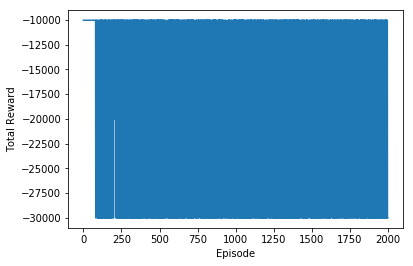

In [6]:
from agents.policy_search import PolicySearch_Agent

num_episodes = 2000
task = Task()
agent = PolicySearch_Agent(task) 

sample_agent = train(agent, num_episodes, plot=True)

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

Using TensorFlow backend.


Episode =  276, Score = 36613.717 (Best = 114764.497, Average = 15908.484), Proximity =   1.140 (Best =  10.000, Average =  26.390), Agent Parameters = {'Mu': 0.02, 'Theta': 0.16, 'Sigma': 0.21, 'Gamma': 0.98, 'Tau': 0.02, 'Learning Rate': 0.0041, 'Dropout Rate': 0.2}}} - Nearly there
Episode =  277, Score = 36613.566 (Best = 114764.497, Average = 22571.635), Proximity =   1.167 (Best =  10.000, Average =  26.390), Agent Parameters = {'Mu': 0.02, 'Theta': 0.16, 'Sigma': 0.21, 'Gamma': 0.98, 'Tau': 0.02, 'Learning Rate': 0.0041, 'Dropout Rate': 0.2}Proximity =   1.146, Agent Parameters = {'Mu': 0.02, 'Theta': 0.16, 'Sigma': 0.21, 'Gamma': 0.98, 'Tau': 0.02, 'Learning Rate': 0.0041, 'Dropout Rate': 0.2}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}

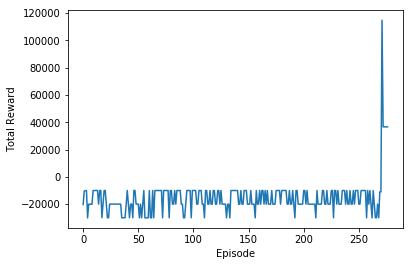

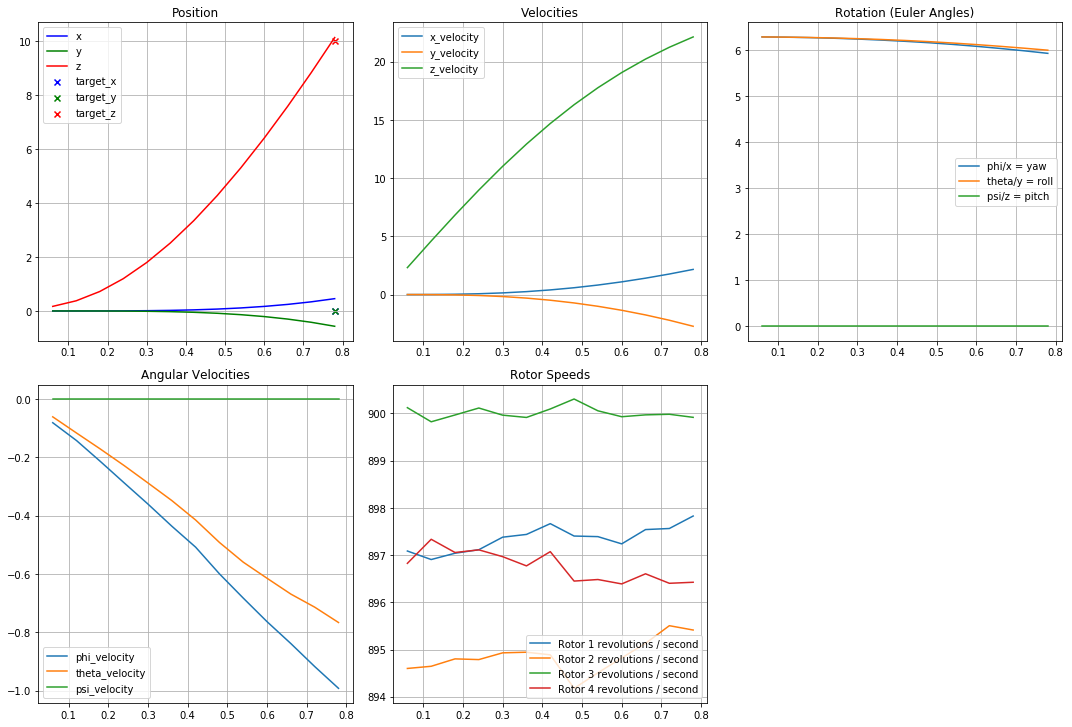

Final Position: [-0.0005146   0.00019591  0.          0.02922275  0.05466998  0.        ] (the position of the quadcopter in ( x,y,zx,y,z ) dimensions and the Euler angles)
Final Velocities: [ -3.61025096e-03   1.35169927e-03  -1.64107116e+00] (the velocity of the quadcopter in ( x,y,zx,y,z ) dimensions)
Final Angular Velocities: [ 0.17253041  0.28815934  0.        ] (radians/second for each of the three Euler angles)


In [7]:
## TODONE: Train your agent here.

from agents.agent import DDPG, DeepQ
num_episodes = 2000

## Training for the takeoff task
takeoff_task = Task()
takeoff_agent = DDPG(takeoff_task)
trained_takeoff = train(takeoff_agent, num_episodes, plot=True)
plot_results(file_write(trained_takeoff), trained_takeoff.task.target_pos)

Episode = 2000, Score = -30283.486 (Best = -10246.058, Average = -28275.440), Proximity =  22.683 (Best =  11.546, Average =  21.829), Agent Parameters = {'Mu': 0.02, 'Theta': 0.16, 'Sigma': 0.21, 'Gamma': 0.98, 'Tau': 0.02, 'Learning Rate': 0.0041, 'Dropout Rate': 0.2}Proximity =  21.954, Agent Parameters = {'Mu': 0.02, 'Theta': 0.16, 'Sigma': 0.21, 'Gamma': 0.98, 'Tau': 0.02, 'Learning Rate': 0.0041, 'Dropout Rate': 0.2}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}

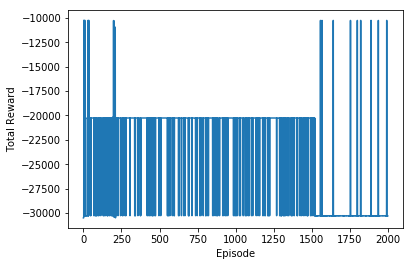

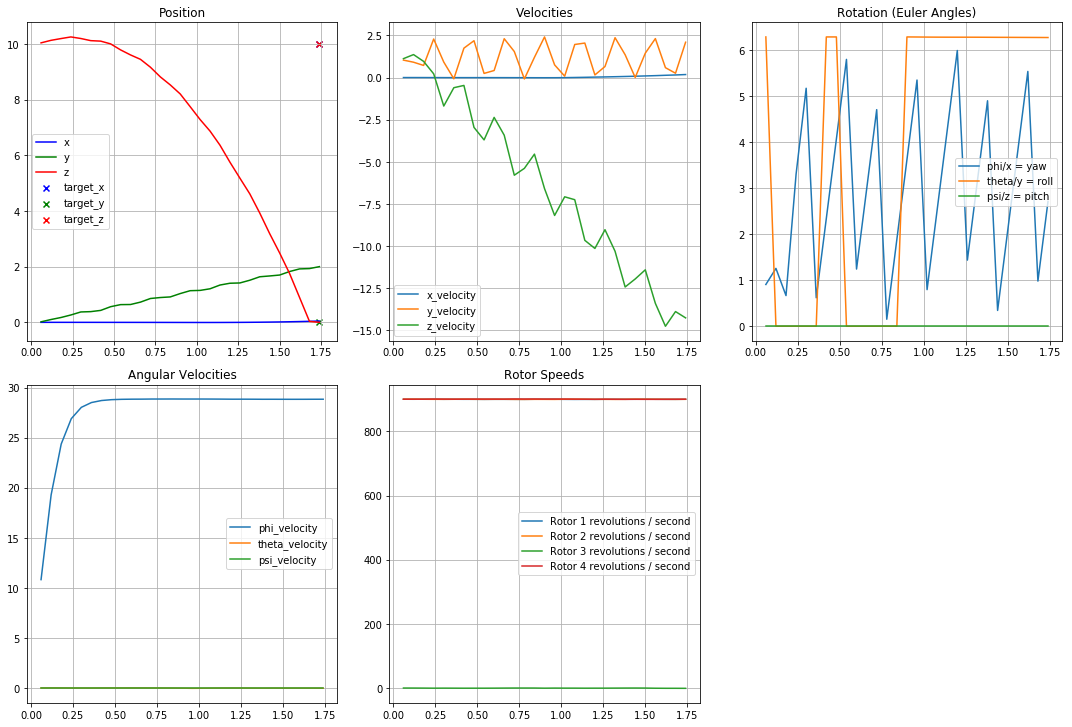

Final Position: [-0.0005146   0.00019591  0.          0.02922275  0.05466998  0.        ] (the position of the quadcopter in ( x,y,zx,y,z ) dimensions and the Euler angles)
Final Velocities: [ -3.61025096e-03   1.35169927e-03  -1.64107116e+00] (the velocity of the quadcopter in ( x,y,zx,y,z ) dimensions)
Final Angular Velocities: [ 0.17253041  0.28815934  0.        ] (radians/second for each of the three Euler angles)


In [8]:
## Training for the target position task
target_task = Task(goal='target')
target_agent = DDPG(target_task)
trained_target = train(target_agent, num_episodes, plot=True)
plot_results(file_write(trained_target), trained_target.task.target_pos)

In [ ]:
## Training for the hover task
hover_task = Task(goal='hover')
hover_agent = DDPG(hover_task)
trained_hover = train(hover_agent, num_episodes, plot=True)
plot_results(file_write(trained_hover), trained_hover.task.target_pos)

Episode =  320, Score = 399528.060 (Best = 983443.422, Average = 464184.918), Proximity =  18.206 (Best =   3.837, Average =  16.003), Agent Parameters = {'Mu': 0.02, 'Theta': 0.16, 'Sigma': 0.21, 'Gamma': 0.98, 'Tau': 0.02, 'Learning Rate': 0.0041, 'Dropout Rate': 0.2}

In [ ]:
## Training for the takeoff task
land_task = Task(goal='land')
land_agent = DDPG(land_task)
trained_land = train(land_agent, num_episodes, plot=True)
plot_results(file_write(trained_land), trained_land.task.target_pos)

In [ ]:
## Training with 100 sets of random values to find an optimal reward_factor
# for run in range(100):
#     task = Task(target_pos=target_pos, grid_search=True)
#     agent = DDPG(task)
#     new_agent = train(agent, num_episodes)
#     trained_agent = new_agent if new_agent.best_score > trained_agent.best_score else trained_agent 

#### Output from some of the best results, running the a random value grid-search within a specified range:
```
Trying: reward_factor=0.66
Episode =  750, score =  -4.813 (best =   2.787), noise_scale = [0, 0.15, 0.2]
Trying: reward_factor=0.37
Episode = 1500, score =  -3.710 (best =   1.750), noise_scale = [0, 0.15, 0.2]
Trying: reward_factor=0.12
Episode = 1500, score =  -9.115 (best =   2.220), noise_scale = [0, 0.15, 0.2]
Trying: reward_factor=1.79
Episode = 1500, score = -30.345 (best =   2.020), noise_scale = [0, 0.15, 0.2]
Trying: reward_factor=0.76
Episode = 1500, score = -39.331 (best =   0.433), noise_scale = [0, 0.15, 0.2]
Trying: reward_factor=0.82
Episode = 2000, score = -13.797 (best =   0.305), noise_scale = [0, 0.15, 0.2]
Trying: reward_factor=0.25
Episode = 2000, score = -17.480 (best =   1.767), noise_scale = [0, 0.15, 0.2]
```
I ran the above algorithm several times overnight (the DDPG trains very slowly, even with a high-end GPU).  First I tried a reward factor range of 0.1 to 10, but soon realized that the best results would come with reward factors under 2, so I tried it again with a range of 0.01 to 3, then again with more episodes to be sure.  I eventually settled on a factor of 0.66.  I know that the values of the scores will vary depending on the reward factor, as it is a part of how the score gets calculated, but generally if the score was positive, it should indicate that the performance was closer to optimal.

Note: the noise_scale printout are the Mu, Theta, Sigma values, and that label was later changed to "Parameters"

In [ ]:
# def better_grid_search(task, num_episodes=750, num_options=100, delta=0.01):
#     """
#     Implements a basic random-exploration gradient descent algorithm to explore optimal values.  ## DEPRECIATED
#     """
#     trained_agent = train(DDPG(task), num_episodes)
#     best_score = trained_agent.best_score
#     best_agent = trained_agent
    
#     mu = trained_agent.exploration_mu
#     theta = trained_agent.exploration_theta
#     sigma = trained_agent.exploration_sigma
    
#     gamma = trained_agent.gamma
#     tau = trained_agent.tau
    
#     for run in range(num_options):
#         new_mu = round(random.uniform(mu-delta, mu+delta), 3)
#         new_theta = round(random.uniform(theta-delta, theta+delta), 3)
#         new_sigma = round(random.uniform(sigma-delta, sigma+delta), 3)
        
#         new_gamma = round(random.uniform(gamma-delta, gamma+delta), 3)
#         new_tau = round(random.uniform(tau-delta, tau+delta), 3)
        
#         print("\r\n\nTrying: Mu={} || Theta={} || Sigma={} ||  Gamma={} || Tau={}".format(
#             new_mu, new_theta, new_sigma, new_gamma, new_tau), end="\r\n")
        
#         task = Task()
#         new_agent = DDPG(task, mu=new_mu, theta=new_theta, sigma=new_sigma, gamma=new_gamma, tau=new_tau)
#         new_agent = train(new_agent, num_episodes)
        
#         if new_agent.best_score > best_score:
#             best_score = new_agent.best_score
#             best_agent = new_agent
            
#             mu, theta, sigma, gamma, tau = new_mu, new_theta, new_sigma, new_gamma, new_tau
            
#     return best_agent
        
# trained_agent = better_grid_search(task, num_episodes=750, num_options=100, delta=0.1)

#### Output from some of the best results, running the my gradient-descent grid-search to optimize the agent's parameters:
```
Trying: Mu=-0.001 || Theta=0.157 || Sigma=0.195 ||  Gamma=0.984 || Tau=0.0
Episode =  750, score =   0.326 (best =   1.095), noise_scale = [-0.001, 0.157, 0.195]
Trying: Mu=0.003 || Theta=0.163 || Sigma=0.198 ||  Gamma=0.986 || Tau=-0.001
Episode =  750, score =  -0.414 (best =   1.088), noise_scale = [0.003, 0.163, 0.198]
Trying: Mu=0.001 || Theta=0.164 || Sigma=0.192 ||  Gamma=0.989 || Tau=-0.007
Episode =  750, score =     nan (best =   1.122), noise_scale = [0.001, 0.164, 0.192]
Trying: Mu=0.001 || Theta=0.17 || Sigma=0.184 ||  Gamma=0.979 || Tau=-0.003
Episode =  750, score =     nan (best =   1.182), noise_scale = [0.001, 0.17, 0.184]
Trying: Mu=0.004 || Theta=0.161 || Sigma=0.184 ||  Gamma=0.978 || Tau=-0.0
Episode =  750, score =   0.202 (best =   1.036), noise_scale = [0.004, 0.161, 0.184]
Trying: Mu=-0.006 || Theta=0.162 || Sigma=0.182 ||  Gamma=0.972 || Tau=-0.004
Episode =  750, score =     nan (best =   1.393), noise_scale = [-0.006, 0.162, 0.182]
Trying: Mu=-0.015 || Theta=0.161 || Sigma=0.173 ||  Gamma=0.973 || Tau=-0.01
Episode =  750, score =     nan (best =   1.023), noise_scale = [-0.015, 0.161, 0.173]
Trying: Mu=-0.014 || Theta=0.171 || Sigma=0.185 ||  Gamma=0.976 || Tau=-0.001
Episode =  750, score =  -0.291 (best =   1.009), noise_scale = [-0.014, 0.171, 0.185]
Trying: Mu=-0.009 || Theta=0.144 || Sigma=0.201 ||  Gamma=0.996 || Tau=0.006
Episode =  750, score =  -1.075 (best =   1.106), noise_scale = [-0.009, 0.144, 0.201]
Trying: Mu=-0.017 || Theta=0.149 || Sigma=0.197 ||  Gamma=1.004 || Tau=0.016
Episode =  750, score =   0.230 (best =   1.191), noise_scale = [-0.017, 0.149, 0.197]
Trying: Mu=-0.024 || Theta=0.152 || Sigma=0.195 ||  Gamma=1.011 || Tau=0.015
Episode =  750, score =  -0.734 (best =   1.016), noise_scale = [-0.024, 0.152, 0.195]
Trying: Mu=0.004 || Theta=0.144 || Sigma=0.206 ||  Gamma=0.981 || Tau=0.04
Episode =  750, score =  -0.182 (best =   1.264), noise_scale = [0.004, 0.144, 0.206]
Trying: Mu=0.01 || Theta=0.134 || Sigma=0.204 ||  Gamma=0.982 || Tau=0.043
Episode =  750, score =  0.506 (best =   1.098), noise_scale = [0.01, 0.134, 0.204]
Trying: Mu=0.004 || Theta=0.154 || Sigma=0.199 ||  Gamma=0.99 || Tau=0.033
Episode =  750, score =  -0.828 (best =   1.032), noise_scale = [0.004, 0.154, 0.199]
Trying: Mu=-0.008 || Theta=0.142 || Sigma=0.19 ||  Gamma=0.988 || Tau=0.015
Episode =  750, score =   0.030 (best =   1.212), noise_scale = [-0.008, 0.142, 0.19]
```
I ran the above algorithm for the better part of a day and then overnight.  While it tried out values with high variation from the defaults, all the best performers have very similar values to the defaults, so I am going to stick with the defaults going forward.

In [ ]:
def versitile_grid_search(agent, task, what="reward", num_episodes=750, num_options=10, goal_proximity=0.1, delta=0.1, min_param=0.001, max_param=1.):
    """
    Implements a basic random-exploration gradient descent algorithm to explore optimal values in the reward function, the agent or both.
    
    Params:
        what (string): Defines what types of parameters we are performing the grid search on:
            "DDPG", "reward", or "batch"
        num_episodes (int): How many episodes to train each permutation of params
        num_options (int): How many options to try before function finishes running
        goal_proximity (float): Indicates what average proximity is close enough to stop the grid_search early
        delta (float): How much exploration is possible each time; higher equals greater variation
        min_param (float): The minimum value for each parameter
        max_param (float): The maximum value for each parameter
    """
    default_task = task()
    default_agent = agent(default_task)
    trained_agent = train(default_agent, num_episodes)
    best_average_proximity = default_task.average_proximity
    best_agent = trained_agent
    best_task = default_task
    
    ## DDPG Agent's parameters
    mu = trained_agent.exploration_mu
    theta = trained_agent.exploration_theta
    sigma = trained_agent.exploration_sigma
    gamma = trained_agent.gamma
    tau = trained_agent.tau
    learning_rate = trained_agent.learning_rate
    dropout_rate = trained_agent.dropout_rate
    
    ## Reward parameters  # DEPRECIATED
    distance = default_task.distance_factor
    angle = default_task.angle_factor
    v = default_task.v_factor
    rotor = default_task.rotor_factor
    elevation = default_task.elevation_factor
    time = default_task.time_factor
    crash = default_task.crash_factor
    target = default_task.target_factor
    
    ## Batch parameters
    buffer = trained_agent.buffer_size 
    batch = trained_agent.batch_size
    
    ## Initialize the new versions of the parameters
    new_mu, new_theta, new_sigma, new_gamma, new_tau, new_lr, new_dropout = mu, theta, sigma, gamma, tau, learning_rate, dropout_rate
    new_distance, new_angle, new_v, new_rotor, new_time, new_elevation, new_crash, new_target = distance, angle, v, rotor, time, elevation, crash, target  # DEPRECIATED
    new_buffer, new_batch = buffer, batch
    
    for run in range(num_options):
        if what is "DDPG":
            ## Feeds the existing best value into the randomizer helper function to try a new permutation
            new_mu = randomizer(mu, delta=delta, min_param=0., max_param=max_param)
            new_theta = randomizer(theta, delta=delta, min_param=min_param, max_param=max_param)
            new_sigma = randomizer(sigma, delta=delta, min_param=min_param, max_param=max_param)
            new_gamma = randomizer(gamma, delta=delta, min_param=min_param, max_param=max_param)
            new_tau = randomizer(tau, delta=delta, min_param=min_param, max_param=max_param)
            new_lr = randomizer(learning_rate, delta=delta, min_param=0.00001, max_param=max_param, decimal_places=5)
            new_dropout = randomizer(dropout_rate, delta=delta, min_param=0.01, max_param=max_param)

            print("\r\n")

            new_task = task()
            new_agent = agent(new_task, mu=new_mu, theta=new_theta, sigma=new_sigma, gamma=new_gamma, tau=new_tau, learning_rate=new_lr, dropout_rate=new_dropout)
            new_agent = train(new_agent, num_episodes)
        
        elif what is "reward":
            ## Scaling the delta and max_param since the reward func might need a wider range to operate within  # DEPRECIATED
            r_delta = delta * 10
            r_max_param = max_param * 10
            new_distance = randomizer(distance, delta=r_delta, min_param=0., max_param=r_max_param)
            new_angle = randomizer(angle, delta=r_delta, min_param=0., max_param=r_max_param)
            new_v = randomizer(v, delta=r_delta, min_param=0., max_param=r_max_param)
            new_rotor = randomizer(rotor, delta=r_delta, min_param=0., max_param=r_max_param)
            new_time = randomizer(time, delta=r_delta, min_param=0., max_param=r_max_param)
            new_elevation = randomizer(elevation, delta=r_delta, min_param=0., max_param=r_max_param)
            new_crash = randomizer(crash, delta=r_delta, min_param=1., max_param=r_max_param)
            new_target = randomizer(target, delta=r_delta, min_param=1., max_param=r_max_param)

            print("\r\n")
        
            new_task = task(distance_factor=new_distance, angle_factor=new_angle, v_factor=new_v, rotor_factor=new_rotor,
                        time_factor=new_time, elevation_factor=new_elevation, crash_factor=new_crash, target_factor=new_target)
            new_agent = DDPG(new_task)
            new_agent = train(new_agent, num_episodes)

        elif what is "batch":
            
            new_buffer = randomizer(buffer, delta=1000000, min_param=10000, max_param=2000000, decimal_places=None)
            new_batch = randomizer(batch, delta=64, min_param=16, max_param=1024, decimal_places=None)
            
            print("\r\n\n Trying: Buffer Size = {} || Batch Size = {}".format(new_buffer, new_batch))
            
            new_task = task()
            new_agent = agent(new_task, buffer_size=new_buffer, batch_size=new_batch)
            new_agent = train(new_agent, num_episodes)
            
        else:
            print("It seems an improper type of task to grid-search was specified.  Please input one of the following options for the param 'what':\
                * 'DDPG'\n* 'reward'\n* 'batch'")
        
        if new_task.average_proximity < 5:
            file_write(new_agent, train_log=True)
        
        if new_task.average_proximity < best_average_proximity:
            best_average_proximity = new_task.average_proximity
            best_agent = new_agent
            best_task = new_task
            
            mu, theta, sigma, gamma, tau, learning_rate, dropout_rate = new_mu, new_theta, new_sigma, new_gamma, new_tau, new_lr, new_dropout
            distance, angle, v, rotor, time, elevation, crash, target = new_distance, new_angle, new_v, new_rotor, new_time, new_elevation, new_crash, new_target  # DEPRECIATED
            buffer, batch = new_buffer, new_batch
            
            if best_task.average_proximity < goal_proximity:
                return best_agent, best_task  # Early stopping
            
    return best_agent, best_task


def randomizer(param, delta=0.1, min_param=0.001, max_param=1., decimal_places=2):
    ## Changes the param to a random number within +/- delta of the param, rounded to decimal_places
    param = round(random.uniform(param-delta, param+delta), decimal_places)
    ## Ensures that the param is within the min/max range allowed, otherwise rounds to the nearest min/max
    param = param if max_param >= param >= min_param else min([min_param, max_param], key=lambda x:abs(x-param))
    return param

#### Output from some of the best results, running the my gradient-descent grid-search to optimize the task's parameters:
```
Episode = 2000, Score = -143.006 (Best =   4.182, Average = -556.532), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.55, 'Angle': 1.74, 'Angular V': 1.0, 'Rotor': 0.32, 'Elevation': 1.47, 'Crash': 1.0, 'Target': 1.0}}

Episode = 2000, Score = -2443.117 (Best = 184.558, Average = -1291.225), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 4.34, 'Angle': 0.001, 'Angular V': 0.001, 'Rotor': 7.2, 'Elevation': 0.001, 'Crash': 1.38, 'Target': 7.49}

Episode = 2000, Score = -1970.560 (Best =  55.988, Average = -1920.264), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 2.56, 'Angle': 3.83, 'Angular V': 9.58, 'Rotor': 3.61, 'Elevation': 2.78, 'Crash': 1.0, 'Target': 6.51}}

Episode = 2000, Score = -6956.303 (Best = 328.891, Average = -4887.862), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 6.06, 'Angular V': 0.001, 'Rotor': 0.001, 'Elevation': 0.001, 'Crash': 9.05, 'Target': 9.88}}}

Episode = 2000, Score = -577.271 (Best = 314.404, Average = -574.790), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 0.001, 'Angular V': 1.45, 'Rotor': 0.001, 'Elevation': 0.001, 'Crash': 1.0, 'Target': 8.42}}

Episode = 2000, Score = -5831.549 (Best = 217.058, Average = -5806.424), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 0.001, 'Angular V': 0.84, 'Rotor': 0.001, 'Elevation': 6.69, 'Crash': 9.31, 'Target': 6.74}}}}

Episode = 2000, Score = -402.930 (Best =  -4.310, Average = -631.827), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 4.1, 'Angle': 0.001, 'Angular V': 0.001, 'Rotor': 0.001, 'Elevation': 9.47, 'Crash': 1.0, 'Target': 1.37}}}

Episode = 2000, Score = -2028.142 (Best =  22.167, Average = -1760.631), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 3.69, 'Angular V': 0.001, 'Rotor': 1.08, 'Elevation': 0.001, 'Crash': 2.49, 'Target': 1.0}

Episode = 2000, Score = -209.824 (Best =  37.036, Average = -4136.036), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 6.51, 'Angular V': 8.66, 'Rotor': 1.13, 'Elevation': 0.001, 'Crash': 5.91, 'Target': 1.0}}}}

Episode = 2000, Score = -449.843 (Best = -52.488, Average = -875.542), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 7.39, 'Angle': 0.09, 'Angular V': 0.001, 'Rotor': 1.21, 'Elevation': 5.54, 'Crash': 1.0, 'Target': 1.0}}}}

Episode = 2000, Score = -1382.794 (Best =  38.270, Average = -943.146), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.05, 'Angle': 2.54, 'Angular V': 0.001, 'Rotor': 0.001, 'Elevation': 0.001, 'Crash': 1.0, 'Target': 1.0}}

Episode = 2000, Score = -462.229 (Best =  27.210, Average = -952.891), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 0.001, 'Angular V': 4.41, 'Rotor': 0.001, 'Elevation': 7.74, 'Crash': 1.0, 'Target': 6.71}}}
```
This run took about a day and a half before I settled on the current default values

```
Episode = 1500, Score = -45383.530 (Best = -13888.897, Average = -38964.289), Proximity =  25.055 (Best =  12.851, Average =  33.064), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 1.0, 'Angle': 1.0, 'Angular V': 1.0, 'Rotor': 1.0, 'Time': 1.0, 'Elevation': 1.0, 'Crash': 1.0, 'Target': 1.0}

Episode = 1500, Score = -74444.703 (Best = -19549.168, Average = -54530.374), Proximity =  38.363 (Best =  11.328, Average =  34.395), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.02, 'Angle': 3.4, 'Angular V': 7.03, 'Rotor': 0.001, 'Time': 0.001, 'Elevation': 0.001, 'Crash': 1.67, 'Target': 3.0}}

Episode = 1500, Score = -206616.988 (Best = -67267.870, Average = -183776.702), Proximity =  88.723 (Best =  18.633, Average =  38.906), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 0.001, 'Angular V': 0.001, 'Rotor': 1.04, 'Time': 0.001, 'Elevation': 5.77, 'Crash': 5.26, 'Target': 4.42}

Episode = 1500, Score = -77342.482 (Best = -117.144, Average = -174779.317), Proximity =  12.146 (Best =   6.188, Average =  60.639), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 2.32, 'Angle': 6.29, 'Angular V': 4.43, 'Rotor': 0.001, 'Time': 0.001, 'Elevation': 2.43, 'Crash': 1.0, 'Target': 1.0}}}}

Episode = 1500, Score = -74698.891 (Best = -27659.113, Average = -130097.604), Proximity =  20.899 (Best =  11.229, Average =  31.253), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 4.7, 'Angular V': 2.34, 'Rotor': 5.42, 'Time': 0.48, 'Elevation': 0.001, 'Crash': 1.0, 'Target': 1.0}}

Episode = 1500, Score = -235062.160 (Best = -103835.384, Average = -297050.435), Proximity =  22.534 (Best =  10.923, Average =  25.959), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 10.0, 'Angular V': 1.04, 'Rotor': 10.0, 'Time': 0.001, 'Elevation': 3.09, 'Crash': 5.18, 'Target': 1.0}

Episode = 1500, Score = -1050544.415 (Best = -187431.169, Average = -326098.433), Proximity = 106.302 (Best =  13.591, Average =  25.950), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 9.89, 'Angular V': 8.11, 'Rotor': 6.51, 'Time': 0.001, 'Elevation': 7.76, 'Crash': 7.05, 'Target': 2.94}

Episode = 1500, Score = -325701.558 (Best = -110037.635, Average = -355212.505), Proximity =  21.989 (Best =  11.674, Average =  36.134), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 5.38, 'Angle': 0.75, 'Angular V': 2.4, 'Rotor': 10.0, 'Time': 5.62, 'Elevation': 10.0, 'Crash': 10.0, 'Target': 1.0}}

Episode = 1500, Score = -67414.837 (Best = 52612.178, Average = -261792.644), Proximity =  28.375 (Best =  14.243, Average =  78.652), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 10.0, 'Angular V': 10.0, 'Rotor': 0.4, 'Time': 9.58, 'Elevation': 9.31, 'Crash': 10.0, 'Target': 1.0}}}}

Episode = 1500, Score = -337478.409 (Best = -150059.567, Average = -386803.057), Proximity =  26.131 (Best =  10.763, Average =  41.787), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 9.4, 'Angle': 10.0, 'Angular V': 0.19, 'Rotor': 7.92, 'Time': 0.001, 'Elevation': 7.09, 'Crash': 8.89, 'Target': 10.0}}

Episode = 1500, Score = -270617.577 (Best = -42845.425, Average = -251479.745), Proximity =  29.432 (Best =  10.289, Average =  30.756), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 5.8, 'Angular V': 1.35, 'Rotor': 10.0, 'Time': 0.001, 'Elevation': 6.14, 'Crash': 4.02, 'Target': 10.0}}}

Episode = 1500, Score = -51010.362 (Best = -18635.021, Average = -60664.394), Proximity =  77.594 (Best =  10.088, Average =  46.083), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 10.0, 'Angular V': 10.0, 'Rotor': 0.001, 'Time': 3.98, 'Elevation': 0.001, 'Crash': 10.0, 'Target': 1.0}}}}

Episode = 1500, Score = -352234.074 (Best = -121435.461, Average = -932703.008), Proximity =  22.019 (Best =  11.394, Average =  60.973), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 0.38, 'Angular V': 10.0, 'Rotor': 10.0, 'Time': 0.001, 'Elevation': 5.78, 'Crash': 10.0, 'Target': 9.98}}}

Episode = 1500, Score = -201879.019 (Best = -85517.036, Average = -406992.079), Proximity =  28.985 (Best =  11.085, Average =  37.570), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 10.0, 'Angular V': 10.0, 'Rotor': 6.84, 'Time': 0.001, 'Elevation': 7.86, 'Crash': 6.05, 'Target': 6.4}}}

Episode = 1500, Score = -320766.076 (Best = -121015.941, Average = -600390.404), Proximity =  21.932 (Best =  10.598, Average =  35.220), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 9.8, 'Angle': 3.05, 'Angular V': 10.0, 'Rotor': 8.07, 'Time': 8.22, 'Elevation': 10.0, 'Crash': 10.0, 'Target': 8.76}}

Episode = 1500, Score = -319419.462 (Best = -231668.469, Average = -484859.930), Proximity =  25.763 (Best =  11.721, Average =  30.816), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 9.74, 'Angle': 1.98, 'Angular V': 9.15, 'Rotor': 10.0, 'Time': 0.001, 'Elevation': 5.58, 'Crash': 10.0, 'Target': 9.01}}
```


#### Output from some of the best results, running the my gradient-descent grid-search to optimize the agent's batch parameters:

```
Episode = 1500, Score = -38844.529 (Best = 41425.256, Average = -42.162), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}}}

 Trying: Buffer Size = 110680 || Batch Size = 112
Episode = 1500, Score = 15220.901 (Best = 33468.834, Average = 14222.449), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}}Score =   0.000, Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}

 Trying: Buffer Size = 109444 || Batch Size = 99
Episode = 1500, Score = 20689.930 (Best = 31039.341, Average = 16702.553), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}Score =   0.000, Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}

 Trying: Buffer Size = 109627 || Batch Size = 147
Episode = 1500, Score = 13908.654 (Best = 38285.600, Average = 16141.401), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}}4}Score =   0.000, Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}

 Trying: Buffer Size = 106196 || Batch Size = 129
Episode = 1500, Score = 15616.086 (Best = 35869.244, Average = 14060.510), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}}}}Score =   0.000, Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.59, 'Angle': 1.29, 'Angular V': 1.02, 'Rotor': 0.01, 'Time': 1.0, 'Elevation': 1.05, 'Crash': 1.06, 'Target': 1.04}
```
This ran overnight.  Note how the scale of scores has changed and how a new parameter is here.  I'd made several refinements and tweaks in-between runs, including changing the score from an average over the episode, to a total.  This made it easier to see if it was crashing early or not.  There were actually several more overnight runs where I didn't save the results since I wasn't happy with any of the performance.

#### Output from some of the best results, running the my gradient-descent grid-search to optimize the reward function parameters (after some tweaks to the base formulas):
```
Episode = 1500, Score = -222559.097 (Best = 24182.961, Average = -90482.539), Proximity =  90.882 (Best =  16.209, Average =  87.732), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}

Episode = 1500, Score = 20324.585 (Best = 34760.153, Average = -82936.077), Proximity =  19.547 (Best =  10.162, Average =  26.228), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 10.0, 'Angular V': 3.22, 'Rotor': 4.66, 'Time': 0.001, 'Elevation': 0.001, 'Crash': 9.22, 'Target': 1.0}}}

Episode = 1500, Score = -172441.064 (Best = 90023.081, Average = -89123.853), Proximity = 162.613 (Best =  10.475, Average = 153.658), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 9.27, 'Angular V': 6.48, 'Rotor': 0.001, 'Time': 0.001, 'Elevation': 0.001, 'Crash': 10.0, 'Target': 1.0}

Episode = 1500, Score = -3037.252 (Best = 25069.408, Average = -152207.594), Proximity =  27.877 (Best =  10.898, Average =  42.577), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 3.65, 'Angle': 10.0, 'Angular V': 0.001, 'Rotor': 0.08, 'Time': 0.001, 'Elevation': 5.75, 'Crash': 10.0, 'Target': 1.0}0}

Episode = 1500, Score = -79424.191 (Best = 16391.898, Average = -111170.330), Proximity =  23.895 (Best =  10.808, Average =  25.398), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 10.0, 'Angular V': 3.96, 'Rotor': 10.0, 'Time': 0.001, 'Elevation': 2.79, 'Crash': 6.67, 'Target': 1.0}}

Episode = 1500, Score = -48686.750 (Best = 33511.999, Average = -596995.475), Proximity =  21.967 (Best =  10.284, Average =  60.407), Agent Parameters = {'Mu': 0, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.99, 'Tau': 0.01}, Task Parameters = {'Distance': 0.001, 'Angle': 0.3, 'Angular V': 10.0, 'Rotor': 5.75, 'Time': 2.24, 'Elevation': 6.88, 'Crash': 10.0, 'Target': 1.0}}
```
This was from another overnight run.

#### Output from some of the best results, running the my gradient-descent grid-search to optimize the agent's parameters:
```
Episode = 1500, Score = -76848.636 (Best = -22660.407, Average = -76859.232), Proximity =  20.585 (Best =  10.930, Average =  20.570), Agent Parameters = {'Mu': 0.0, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.98, 'Tau': 0.01, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}}


Episode =   72, Score = -54250.074 (Best = -2251.987, Average = -73091.610), Proximity =  38.395 (Best =  11.540, Average =  27.522), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}}}Success!  (•̀ᴗ•́)و ̑̑  
Episode =   79, Score = -64687.474 (Best = -2251.987, Average = -49115.036), Proximity =  68.325 (Best =  11.540, Average =  28.010), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =   82, Score = -64285.333 (Best = -2251.987, Average = -44512.266), Proximity =  33.941 (Best =  11.540, Average =  27.620), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =   84, Score = -63097.975 (Best = -2251.987, Average = -45384.866), Proximity =  35.627 (Best =  11.540, Average =  27.662), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =   86, Score = -13332.838 (Best = 593.860, Average = -40006.682), Proximity =  13.077 (Best =  11.540, Average =  27.587), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =   89, Score = -47074.452 (Best = 593.860, Average = -27081.101), Proximity =  43.634 (Best =  11.540, Average =  27.666), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =   95, Score = -45741.897 (Best = 593.860, Average = -37527.827), Proximity =  21.596 (Best =  11.540, Average =  27.843), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =   96, Score =  67.967 (Best = 593.860, Average = -36187.746), Proximity =   1.305 (Best =  11.540, Average =  27.843), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =   98, Score = -16891.009 (Best = 593.860, Average = -35370.546), Proximity =  18.862 (Best =  11.540, Average =  27.799), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  100, Score = -72215.509 (Best = 906.940, Average = -35104.333), Proximity =  30.928 (Best =  11.540, Average =  27.839), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  102, Score = -54234.482 (Best = 3695.370, Average = -27324.734), Proximity =  35.546 (Best =  11.540, Average =  27.910), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  105, Score = -52774.617 (Best = 3695.370, Average = -27011.527), Proximity =  19.641 (Best =  11.540, Average =  27.996), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  108, Score = -112000.819 (Best = 3695.370, Average = -41648.137), Proximity =  57.993 (Best =  11.540, Average =  28.436), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  110, Score = -31690.448 (Best = 3695.370, Average = -37614.489), Proximity =  24.720 (Best =  11.540, Average =  28.419), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  119, Score = -74695.512 (Best = 3695.370, Average = -54387.238), Proximity =  42.433 (Best =  11.540, Average =  29.193), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  121, Score = -43058.608 (Best = 3695.370, Average = -55004.587), Proximity =  39.808 (Best =  11.540, Average =  29.237), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  123, Score = -45142.616 (Best = 3695.370, Average = -50497.522), Proximity =  40.228 (Best =  11.540, Average =  29.328), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  125, Score = -89074.295 (Best = 3695.370, Average = -42921.448), Proximity = 174.402 (Best =  11.540, Average =  30.521), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  127, Score = -45877.370 (Best = 3695.370, Average = -36245.818), Proximity =  19.481 (Best =  11.540, Average =  30.383), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  128, Score = -2035.362 (Best = 3695.370, Average = -29857.709), Proximity =   1.733 (Best =  11.540, Average =  30.383), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  129, Score = -3502.942 (Best = 3695.370, Average = -22738.452), Proximity =   1.912 (Best =  11.540, Average =  30.383), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  130, Score = 3486.471 (Best = 3695.370, Average = -22752.131), Proximity =   0.315 (Best =  11.540, Average =  30.383), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  134, Score = -51302.928 (Best = 3695.370, Average = -26510.839), Proximity =  15.498 (Best =  11.540, Average =  30.149), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  138, Score = -34739.666 (Best = 3695.370, Average = -30999.395), Proximity =  13.924 (Best =  11.540, Average =  30.367), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  139, Score = 2988.981 (Best = 3695.370, Average = -30350.202), Proximity =   0.609 (Best =  11.540, Average =  30.367), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  141, Score = -13791.252 (Best = 3695.370, Average = -32088.072), Proximity =  13.096 (Best =  11.540, Average =  30.300), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  158, Score = -64014.953 (Best = 3695.370, Average = -66262.996), Proximity =  25.599 (Best =  11.540, Average =  34.878), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}}Success!  (•̀ᴗ•́)و ̑̑  
Episode =  160, Score = -74699.475 (Best = 3695.370, Average = -62912.001), Proximity =  34.629 (Best =  11.540, Average =  34.870), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  161, Score = 2858.742 (Best = 3695.370, Average = -46161.783), Proximity =   0.787 (Best =  11.540, Average =  34.870), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode =  166, Score = -60031.021 (Best = 3695.370, Average = -51117.787), Proximity =  44.385 (Best =  11.540, Average =  37.940), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}}Success!  (•̀ᴗ•́)و ̑̑  
Success!  (•̀ᴗ•́)و ̑̑  
Episode = 1500, Score = -61592.139 (Best = 3695.370, Average = -70463.578), Proximity =  27.928 (Best =  10.095, Average =  75.249), Agent Parameters = {'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02, 'Learning Rate': 0.001}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}}}

```
This inspired me to implement a stopping condition into the train function.  It came after running the grid search for over 48 hours without significant terminal performance gains.  I realized that the agent would discover the optimal policy, then wander away from it in later episodes.

In [ ]:
# DDPG_agent, DDPG_task = versitile_grid_search(DDPG, Task, what="DDPG", num_episodes=2000, num_options=20, delta=.01, goal_proximity=0.75)

# plot_results(file_write(DDPG_agent), target_pos)
# total_rewards_plot(DDPG_agent.total_score)

#### Output from some of the best results, running the my gradient-descent grid-search to optimize the agent's parameters:
```
Episode =   14, Score = 120089.925 (Best = 187190.009, Average = 81247.897), Proximity =   1.031 (Best =   4.589, Average =  24.499), Agent Parameters = {'Mu': 0.02, 'Theta': 0.15, 'Sigma': 0.2, 'Gamma': 0.98, 'Tau': 0.02, 'Learning Rate': 0.00942, 'Dropout Rate': 0.2}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}

Episode =  598, Score = 120039.331 (Best = 178090.604, Average = 87228.138), Proximity =   1.213 (Best =   6.602, Average =  10.769), Agent Parameters = {'Mu': 0.03, 'Theta': 0.16, 'Sigma': 0.19, 'Gamma': 1.0, 'Tau': 0.01, 'Learning Rate': 0.00414, 'Dropout Rate': 0.19}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}

Episode = 1044, Score = 178090.595 (Best = 178090.595, Average = 88213.971), Proximity =   0.843 (Best =   2.828, Average =  11.078), Agent Parameters = {'Mu': 0.02, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.001, 'Learning Rate': 0.0041, 'Dropout Rate': 0.2}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}

Episode = 1778, Score = 187190.087 (Best = 187190.087, Average = 88191.535), Proximity =   0.827 (Best =   9.618, Average =  16.030), Agent Parameters = {'Mu': 0.02, 'Theta': 0.13, 'Sigma': 0.22, 'Gamma': 0.99, 'Tau': 0.01, 'Learning Rate': 0.00081, 'Dropout Rate': 0.2}, Task Parameters = {'Distance': 2.3, 'Angle': 6.3, 'Angular V': 4.5, 'Rotor': 0.1, 'Time': 0.1, 'Elevation': 2.4, 'Crash': 1.0, 'Target': 1.0}
```
Once I developed a reward function that seems to work pretty well and a technique to stop on working weights, I decided to run the grid-search overnight again just to be sure I was using the best agent parameters.

In [ ]:
# rewards_agent, rewards_task = versitile_grid_search(DDPG, Task, what="reward", num_episodes=500, num_options=10, delta=.1, goal_proximity=0.5)

# plot_results(file_write(rewards_agent), target_pos)
# total_rewards_plot(rewards_agent.total_score)

In [ ]:
# batch_agent, batch_task = versitile_grid_search(DDPG, Task, what="batch", num_episodes=2000, num_options=10, goal_proximity=0.75)

# plot_results(file_write(batch_agent), target_pos)
# total_rewards_plot(batch_agent.total_score)

#### Output from some of the best results, running the my gradient-descent grid-search to optimize the agent's batch parameters:
```
 Trying: Buffer Size = 2000000 || Batch Size = 54
Episode =  257, Score = 120039.613 (Best = 187189.505, Average = 64643.202), Proximity =   1.025 (Best =  10.000, Average =  42.459)

 Trying: Buffer Size = 2000000 || Batch Size = 84
Episode = 1777, Score = 178090.413 (Best = 178090.622, Average = 87216.567), Proximity =   0.847 (Best =  10.001, Average =  13.522)

 Trying: Buffer Size = 910639 || Batch Size = 129
Episode =   23, Score = 39710.759 (Best = 114763.426, Average = 37258.443), Proximity =   1.342 (Best =  12.164, Average =  27.530)

 Trying: Buffer Size = 913677 || Batch Size = 113
Episode = 1427, Score = 126137.028 (Best = 126137.967, Average = 53606.208), Proximity =   1.280 (Best =   6.531, Average =  40.630)
```
With a usually successful agent and reward function, I ran the batch grid search again to ensure I was using the optimal batch parameters.

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [ ]:
## TODONE: Plot the rewards.

# plot_results(file_write(trained_agent), target_pos)

In [ ]:
# total_rewards_plot(trained_agent.total_score)

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
I designed the reward function to return a very negative reward if the agent crashes, a near(ish)-to-zero reward if it does not reach the target yet doesn't crash, and a very large positive reward if it reaches the target.  I used the starter reward function (subtracting the distance to target at each timestep), then added in a big penalty for crashing and a big reward for getting within a specific distance (`accuracy factor`) to the target.

Originally, I started out with a very simple reward function, but wasn't getting acceptable performance.  So I slowly added various feedback mechanisms for different aspects of performance that would usually correspond (convergent goals) to reaching the target via stable flight (terminal goal), such as yaw/pitch/roll thresholds and penalties if rotor speeds drasticaly differ from one rotor to another.  Then I also included a large penalty for crashing and a large reward for reaching the target (within a certain accuracy using the `min_accuracy` variable).  For the land, takeoff and go-to-target goals, I added a way to stop the episode when the agent reached the target, but couldn't do that for hover, since the point is to stay at the target for a set amount of time.  Furthermore, I wasn't sure if my formulas for rewarding/penalizing were appropriatly weighted, especially in relation to one another, so I added separate varables to scale each factor independantly and used that in a grid search function as a way to test out various combinations of formula weights.

However, I still couldn't achieve performance that was anywhere near acceptable.  Then I decided to simplify my reward function to its current state, with just 1 factor for distance to target + a large reward/penalty based on whether the terminal state was a success or not.  After that I finally started reaching the goal more consistently.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- I started out trying to get the DDPG algorithm to work, which wasn't quite learning the task and was taking forever to train.  So I tried implementing a simple DeepQ Network, which took even longer to train and performed just as poorly.  So I switched back to trying to get the DDPG to learn.
- I eventually settled on numbers very close to the default hyperparameters that the Udacity provided starter code included: `{'Mu': 0.01, 'Theta': 0.14, 'Sigma': 0.21, 'Gamma': 0.99, 'Tau': 0.02}`  However, this was only after extensive testing of various combinations of parameters via a (crude) random-exploration gradient descent algorithm to test various combinations of hyperparameters.  All of the best performing combinations had values similar to the defaults.
- I started with the default architecture that comes with the Udacity DDPG code, then later tried adding Dropout and BatchNormalization layers in both the Actor and Critic models, but I didn't discern any performance increase, so I've turned those off for now.  I did add kernel regularizers and kernel initilaizers, which seemed to help slightly.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
- This task was relatively easy to learn when I figured out the right ways to reward the agent.  In earlier trials, it learned the task in as few as 100 episodes.
- The learning starts out promising looking, usually with the best performance being achieved within the first 200 episodes, however after that it tries to exploit rewards based on a flawed policy.  Oddly enough, I couldn't seem to influence this pattern when trying all kinds of different noise parameters.  Later I added a stopping feature to the train function so that it would stop training if the agent achieved the goal 3 times in a row, thus staying at an optimal policy.
- The final performance of the agent was very high, with about a mean reward of 22k.  I implemented a stopping feature on the training function so that once the agent started succeeding a majority of the time, we'd stick with those weights.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- The hardest part of this project by far was the lack of support and guidance.  The Reinforcement Learning section had very little hands on work, and didn't really cover many of the concepts necessary to tackle this problem.  The usually great support methods from Udacity were completely silent this time: my mentors have been unresponsive, the Slack channel only has other students with a similar feeling of being lost, and my post on Knowledge has been ignored.  I've had to do a lot of searching on my own, reading academic papers and Medium articles, even paying for a course on Udemy to help fill in the gaps.  Once I figured out that my reward function needed some terminal condions, but otherwise couldn't be too complicated, things got easier.
- I found it interesting that the agent seems to learn better with simpler reward functions.  When the agent wasn't learning at first, I kept adding more and more guidance for optimal behavior by specifying convergent goals, but this didn't seem to help it learn.  However, once I removed those goals and only had terminal goals, then it would learn just fine, even hitting those convergent goals along the way.

## Below is a depreciated grid_search script that I originally had in the DDPG agent and the task respectively.
-----
When I wrote the better and versitile grid_search functions in this notebook, I didn't need these anymore.

In [ ]:
        ## DEPRECIATED
        # if grid_search:
        #     ## Set values based on a random range of possibilities to be used for simple grid_search (change grid_search to True to use this feature)
        #     self.exploration_mu = round(random.uniform(0.001, 1.), 3)
        #     self.exploration_theta = round(random.uniform(0.001, 1.), 3)
        #     self.exploration_sigma = round(random.uniform(0.001, 1.), 3)
        #
        #     self.gamma = round(random.uniform(0.1, 1.), 3)
        #     self.tau = round(random.uniform(0.001, 0.1), 3)
        #
        #     print("\rTrying: Mu={} || Theta={} || Sigma={} ||  Gamma={} || Tau={}".format(
        #         self.exploration_mu, self.exploration_theta, self.exploration_sigma,
        #         self.gamma, self.tau), end="\r\n")

In [ ]:
        # self.reward_factor = reward_factor  # Default value is 1 ## DEPRECIATED
    
        ## DEPRECIATED
        # if grid_search:
        #     ## Set values based on a random range of possibilities to be used for simple grid_search (change grid_search to True to use this feature)
        #     self.reward_factor = round(random.uniform(0.01, 3.), 2)
        #     print("\r\nTrying: reward_factor={}".format(self.reward_factor), end="\r\n")